In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [67]:
initial_data = pd.read_csv('./data/heart_attack_prediction_dataset.csv')
target = initial_data["Heart Attack Risk"]
data = initial_data.drop(columns=["Patient ID", "Heart Attack Risk"])
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(exclude=['object']).columns
print(" Columns with numerical values are :", list(numerical_columns),"\n","Columns with categorical values are :", list(categorical_columns))

categorical_data = initial_data[categorical_columns]
numerical_data  = initial_data[numerical_columns]

 Columns with numerical values are : ['Age', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day'] 
 Columns with categorical values are : ['Sex', 'Blood Pressure', 'Diet', 'Country', 'Continent', 'Hemisphere']


### Data preparation

As seen before, there are no missing values in our dataset. We only need to scale our data and split it into train/dev/test.

In [68]:
data["Blood Pressure"].head()

0     158/88
1     165/93
2     174/99
3    163/100
4      91/88
Name: Blood Pressure, dtype: object

The feature "Blood Pressure" is expressed as a ratio of two numbers, like "158/88" or "165/93." These values represent blood pressure measurements in millimeters of mercury (mm Hg) and are typically written in the form of "systolic/diastolic" blood pressure. We'll use these values to categorize the blood pressure into different ranges: 

    Normal Blood Pressure:
        Systolic Pressure: Less than 120 mm Hg
        Diastolic Pressure: Less than 80 mm Hg

    Elevated Blood Pressure:
        Systolic Pressure: 120-129 mm Hg
        Diastolic Pressure: Less than 80 mm Hg

    Hypertension Stage 1:
        Systolic Pressure: 130-139 mm Hg
        Diastolic Pressure: 80-89 mm Hg

    Hypertension Stage 2:
        Systolic Pressure: 140 mm Hg or higher
        Diastolic Pressure: 90 mm Hg or higher

    Hypertensive Crisis:
        Systolic Pressure: Higher than 180 mm Hg
        Diastolic Pressure: Higher than 120 mm Hg

In [69]:
# Function to categorize blood pressure
def categorize_blood_pressure(blood_pressure):
    systolic, diastolic = map(int, blood_pressure.split('/'))
    if systolic < 120 or diastolic < 80:
        return 'Normal'
    elif systolic < 130 or diastolic < 80:
        return 'Elevated'
    elif systolic < 140 or diastolic < 90:
        return 'Hypertension Stage 1'
    elif systolic >= 140 or diastolic >= 90:
        return 'Hypertension Stage 2'
    else:
        return 'Unknown'


data['Blood Pressure'] = data['Blood Pressure'].apply(categorize_blood_pressure)

data['Blood Pressure'].value_counts()

Blood Pressure
Normal                  5139
Hypertension Stage 2    1685
Hypertension Stage 1    1348
Elevated                 591
Name: count, dtype: int64

We can see that many patients suffer from high blood pressure

In [70]:
print(data["Sex"].value_counts(),"\n")
print(data["Diet"].value_counts(),"\n")
print(data["Country"].value_counts(),"\n")


Sex
Male      6111
Female    2652
Name: count, dtype: int64 

Diet
Healthy      2960
Average      2912
Unhealthy    2891
Name: count, dtype: int64 

Country
Germany           477
Argentina         471
Brazil            462
United Kingdom    457
Australia         449
Nigeria           448
France            446
Canada            440
China             436
New Zealand       435
Japan             433
Italy             431
Spain             430
Colombia          429
Thailand          428
South Africa      425
Vietnam           425
United States     420
India             412
South Korea       409
Name: count, dtype: int64 



In [71]:
print(data["Continent"].value_counts(),"\n")
print(data["Hemisphere"].value_counts(),"\n")

Continent
Asia             2543
Europe           2241
South America    1362
Australia         884
Africa            873
North America     860
Name: count, dtype: int64 

Hemisphere
Northern Hemisphere    5660
Southern Hemisphere    3103
Name: count, dtype: int64 



Of course features "Country", "Continent" and "Hemisphere" will be correlated. So for now, we decide to keep feature "Continent" only.

In [72]:
data = data.drop(columns=["Country", "Hemisphere"])
categorical_columns = categorical_columns[categorical_columns != "Country"]
categorical_columns = categorical_columns[categorical_columns != "Hemisphere"]

We'll use a categorical encoder to see the correlation between our categorical attributes. But later, we'll use a one-hot-encoder. 

In [120]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
categorical_data_encoded = pd.DataFrame(ordinal_encoder.fit_transform(categorical_data), columns=categorical_data.columns)
correlation_matrix = np.corrcoef(categorical_data_encoded, rowvar=False)
print(correlation_matrix)

[[ 1.         -0.00675454 -0.00804504  0.01650096 -0.01690162 -0.00307503]
 [-0.00675454  1.          0.00313134  0.02725923 -0.0187206  -0.0018703 ]
 [-0.00804504  0.00313134  1.         -0.0078969   0.01659173  0.00951113]
 [ 0.01650096  0.02725923 -0.0078969   1.         -0.44425409 -0.29270998]
 [-0.01690162 -0.0187206   0.01659173 -0.44425409  1.          0.22096295]
 [-0.00307503 -0.0018703   0.00951113 -0.29270998  0.22096295  1.        ]]


It seems that the correlation between these features is very low

## Definition of the pipeline

We use a standard scaler to scale our numerical values and and a one hot encoder to encode our categorical ones

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_pipeline = Pipeline([
    ("scaler",StandardScaler())
])
cat_pipeline = Pipeline([(
     ("cat_encoder", OneHotEncoder(sparse=False))
)])

In [76]:
from sklearn.compose import ColumnTransformer

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_columns),
        ("cat", cat_pipeline, categorical_columns),
    ])

We use a stratified split in order to ensure that the distribution of the target variable is preserved in both the training and test sets.

In [77]:
# Splitting the data
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


In [78]:
for train_index, test_index in sss.split(data, target):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

In [83]:
X_train = preprocess_pipeline.fit_transform(
    train_data)
X_train

/home/aymane/Desktop/3A/LOGIN/AAA/Project/env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[-1.54117005, -0.12804283,  0.14343647, ...,  0.        ,
         0.        ,  0.        ],
       [-0.59683639, -1.09050277,  0.38615593, ...,  0.        ,
         0.        ,  0.        ],
       [-0.40796966, -1.26325199,  0.43469983, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.81966411,  1.64880628,  1.64829715, ...,  0.        ,
         0.        ,  1.        ],
       [-0.03023619,  1.71050243, -0.58472192, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.44193064, -0.42418435,  0.92013875, ...,  0.        ,
         0.        ,  0.        ]])

# Try different models

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

lregression = LogisticRegression(class_weight='balanced',random_state=42)
rfclassifier = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=6)
xgbclassifier = XGBClassifier(random_state=42)
svc = SVC(random_state=42,kernel="sigmoid", class_weight='balanced')
mlpclassifier = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='lbfgs',random_state=42, max_iter=2000, learning_rate="invscaling")
models = [lregression, rfclassifier, xgbclassifier, svc, mlpclassifier]
names = ["LogisticRegression", "RandomForestClassifier", "XGBClassifier", "SVC", "MLPClassifier"]

In [118]:
from sklearn.metrics import classification_report,f1_score
from sklearn.model_selection import cross_val_score

classification_reports, Scores, f1_scores = {}, {}, {}
for classifier, name in zip(models, names):
    scores = cross_val_score(classifier, X_train, y_train, cv=10)
    X_test = preprocess_pipeline.transform(test_data)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(f"Score of {name} : ", scores.mean())
    Scores[name] = scores
    f1 = f1_score(y_test, y_pred)
    print(f"F1 score of {name} on test data : ", f1)
    f1_scores[name] = f1
    print(f"Summary of {name} on test data : \n", classification_report(y_test, y_pred))
    classification_reports[name] = classification_report


Score of LogisticRegression :  0.5054208273894437
F1 score of LogisticRegression on test data :  0.41807147673634526
Summary of LogisticRegression on test data : 
               precision    recall  f1-score   support

           0       0.65      0.52      0.57      1125
           1       0.36      0.49      0.42       628

    accuracy                           0.51      1753
   macro avg       0.50      0.50      0.50      1753
weighted avg       0.54      0.51      0.52      1753

Score of RandomForestClassifier :  0.638231098430813
F1 score of RandomForestClassifier on test data :  0.015527950310559006
Summary of RandomForestClassifier on test data : 
               precision    recall  f1-score   support

           0       0.64      0.99      0.78      1125
           1       0.31      0.01      0.02       628

    accuracy                           0.64      1753
   macro avg       0.48      0.50      0.40      1753
weighted avg       0.52      0.64      0.51      1753

Score 

We plot accuracy values and f1 scores for each model to have a better visualization of the results


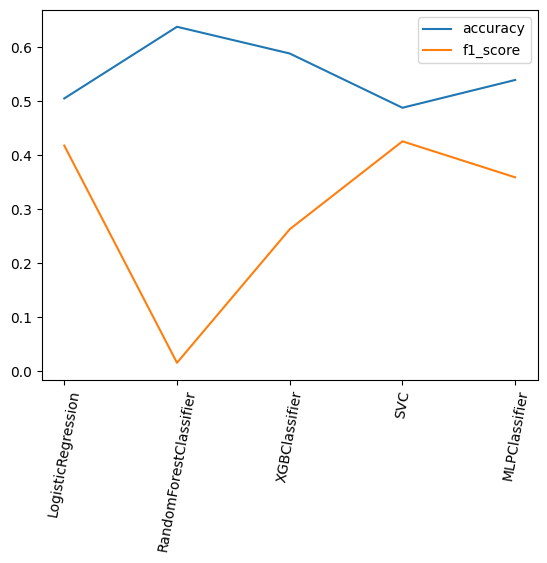

In [119]:
plt.plot(Scores.keys(), [scores.mean() for scores in Scores.values()], label = "accuracy")
plt.plot(f1_scores.keys(),f1_scores.values(), label = "f1_score")
plt.legend()
plt.xticks(rotation = 80)
plt.show()

The plot represent accuracy values as well as F1-score values for each model. We can see an inverse relationship between accuracy and F1-score. In fact, given that our classes are imbalanced (65% instances of class 0 and 35% of class 1), a model can achieve high accuracy by simply predicting the majority class for most instances. But the F1-score takes into account both precision and recall, providing a more balanced measure that considers false positives and false negatives. This is why F1-score can be a more informative metric, 

